In [2]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')

In [52]:
import math
from tqdm import tqdm
from torch import Tensor
from typing import Tuple, List


class Triangle:
    def __init__(self, v0, v1, v2):
        self.v0 = v0
        self.v1 = v1
        self.v2 = v2
        
    def get_min_pos(self):
        return (
            min(self.v0[0].item(), self.v1[0].item(), self.v2[0].item()),
            min(self.v0[1].item(), self.v1[1].item(), self.v2[1].item())
        )
    
    def get_max_pos(self):
        return (
            max(self.v0[0].item(), self.v1[0].item(), self.v2[0].item()),
            max(self.v0[1].item(), self.v1[1].item(), self.v2[1].item())
        )
    
    def compute_color(self, bar_coords: Tuple[float, float, float], img: Tensor):
        return self.get_color(self.v0, img) * bar_coords[0] + \
               self.get_color(self.v1, img) * bar_coords[1] + \
               self.get_color(self.v2, img) * bar_coords[2]
    
    def get_color(self, vertex, img):
        return img[vertex[0].round().long().item()][vertex[1].round().long().item()]
        
        
# class Vertex:
#     def __init__(self, x, y, color: Tensor):
#         self.pos = (x, y)
#         self.color = color


def triangle_interpolation(coords: Tensor, img: Tensor):
    """
    Takes a full image, selects coordinates from it and performs the interpolation
    Coords have the shape [grid_height, grid_width, 2]
    """
    grid_height, grid_width = coords.shape[0], coords.shape[1]
    
    # Let's collect the triangles first
    print('Collecting triangles...')
    triangles = []
    for i in range(grid_height - 1):
        for j in range(grid_width - 1):
            if i % 2 == j % 2:
                v0, v1, v2 = coords[i][j], coords[i+1][j+1], coords[i+1][j]
                u0, u1, u2 = coords[i][j], coords[i][j+1], coords[i+1][j+1]
            else:
                v0, v1, v2 = coords[i][j], coords[i][j+1], coords[i+1][j]
                u0, u1, u2 = coords[i+1][j], coords[i][j+1], coords[i+1][j+1]
            
            triangles.append(Triangle(v0, v1, v2))
            triangles.append(Triangle(u0, u1, u2))
    
    # Then, we loop over the triangles and rasterize them using barycentric coordinates
    return rasterize_triangles(triangles, img.shape[0], img.shape[1], img)
    
    
def rasterize_triangles(triangles: List[Triangle], h, w, full_image: Tensor) -> Tensor:
    """
    Takes the triangles and rasterizes them to a given height and width.
    Also takes the full image for querying colors
    """
    result = torch.zeros(h, w, 3)
    
    for triangle in tqdm(triangles, desc='Rasterizing triangles'):
        min_pos, max_pos = triangle.get_min_pos(), triangle.get_max_pos()
        area = compute_det_from_points(triangle.v0, triangle.v1, triangle.v2);
        
        for x in range(math.floor(min_pos[0]), math.ceil(max_pos[0])):
            for y in range(math.floor(min_pos[1]), math.ceil(max_pos[1])):
                pixel_pos = (x, y)
                bar_coords = (
                    compute_det_from_points(triangle.v1, triangle.v2, pixel_pos) / area,
                    compute_det_from_points(triangle.v2, triangle.v0, pixel_pos) / area,
                    compute_det_from_points(triangle.v0, triangle.v1, pixel_pos) / area,
                )

                if bar_coords[0] < 0 or bar_coords[1] < 0 or bar_coords[2] < 0:
                    continue
                
#                 if result[y][x].abs().sum() != 0:
#                     print('We have already colored this pixel:', result[y][x])
                result[y][x] = triangle.compute_color(bar_coords, full_image)
                
    return result.permute(2, 0, 1)


def compute_det_from_points(u: Tuple[float, float], v: Tuple[float, float], point: Tuple[float, float]) -> float:
    return (point[0] - u[0]) * (v[1] - u[1]) - (point[1] - u[1]) * (v[0] - u[0])

In [53]:
img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
img = torch.from_numpy(np.array(img))
x_coords = torch.arange(0, 127, 2).view(1, -1).repeat(64, 1).float()
coords = torch.stack([x_coords.t(), x_coords]).permute(1, 2, 0)

In [54]:
result = triangle_interpolation(coords, img)

Rasterizing triangles:   1%|          | 64/7938 [00:00<00:12, 638.05it/s]

Rasterizing triangles: 100%|██████████| 7938/7938 [00:09<00:00, 861.99it/s]


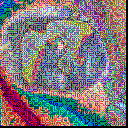

In [57]:
import torchvision.transforms.functional as TVF

TVF.to_pil_image(result)

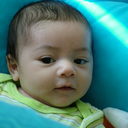

In [59]:
TVF.to_pil_image(img.permute(2, 0, 1))